In [65]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata

import palettable
from IPython.display import display

from joblib import parallel_backend
from scipy.stats import ranksums
from harmony import harmonize
from statsmodels.stats.multitest import multipletests

import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import pearsonr, wilcoxon



sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


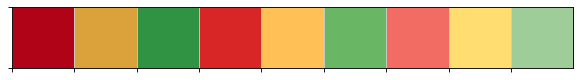

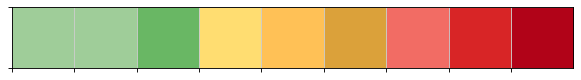

In [8]:
colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(colors)
sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(list(range(9)), colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap[0] = palettable.tableau.TableauMedium_10.mpl_colors[-1]

In [9]:
cytof_adir = '../../../../data/InVivo/Cytof/'
cytof_project_name = 'Full_IRF_SerialSac_Cytof_Fixid.1M'

seqwell_adir = '../../../../data/InVivo/Seqwell/'
seqwell_project_name = 'invivo_all_20200318_mmul8_V4_fixid'
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

gcs = False

results_dir = '../../../../results'

## Load processed CYTOF data

In [10]:
cytoffn = os.path.join(cytof_adir, cytof_project_name + '.DoubletFilt.COMBAT.SubtractCNMF.SubclusterBMyeloidTNK.UMAP.Final.UMAPdata.tsv')

cytof = pd.read_csv(cytoffn, sep='\t', index_col=0)
cytof.head()

,DPI,DPIc,Multiplex_Barcode,Multiplex_Group,Period,animal,clinical_score,context,intensity_sum,is_doublet,...,Subclustering_clean,dpi_color,cluster_color,Multiplex_Group_Num,Multiplex_Group_Color,Ki67,CD38,HLA-DR,CD14,CD16
NHP07.D003.LIVE_34361-0,3,3,102_106_110,Barcode tube 2,Early,NHP07,0.0,LIVE,67.565610,False,...,Monocyte,#FFDD71,#2CA02C,2,#17BECF,1.194755,0.088050,4.446310,2.251268,4.320044
NHP07.D003.LIVE_116133-0,3,3,102_106_110,Barcode tube 2,Early,NHP07,0.0,LIVE,76.927710,False,...,Monocyte,#FFDD71,#2CA02C,2,#17BECF,1.671701,0.272825,3.999717,2.481711,1.392663
NHP07.D003.LIVE_117138-0,3,3,102_106_110,Barcode tube 2,Early,NHP07,0.0,LIVE,57.286858,False,...,Monocyte,#FFDD71,#2CA02C,2,#17BECF,1.577229,0.200688,3.195812,2.290937,0.664079
NHP07.D003.LIVE_94776-0,3,3,102_106_110,Barcode tube 2,Early,NHP07,0.0,LIVE,74.445320,False,...,Monocyte,#FFDD71,#2CA02C,2,#17BECF,1.279226,-0.064928,3.727512,1.516056,0.611337
NHP07.D003.LIVE_69626-0,3,3,102_106_110,Barcode tube 2,Early,NHP07,0.0,LIVE,68.663300,False,...,Monocyte,#FFDD71,#2CA02C,2,#17BECF,0.979667,0.664166,4.480372,3.089545,4.219157


In [11]:
frac_per_day_cytof = pd.crosstab(cytof['Subclustering_clean'], cytof['Period'])
frac_per_day_cytof = frac_per_day_cytof.div(frac_per_day_cytof.sum(axis=1), axis=0)
frac_per_day_cytof*100

Period,Baseline,Early,Incubation,Late,Mid
Subclustering_clean,,,,,
B,36.025793,10.450172,25.802385,13.080134,14.641516
Basophil,17.900172,5.507745,27.309237,45.553643,3.729203
Monocyte,25.719196,18.151014,17.383031,17.451965,21.294795
NK,32.936773,5.423740,27.690148,20.441786,13.507552
Neutrophil,9.264917,4.850878,4.436393,49.804866,31.642946
Plasmablast,10.886806,4.686373,7.570296,66.258111,10.598414
T CD4+,30.069831,8.686693,20.915396,24.458820,15.869259
T CD8+,32.220627,9.695302,19.212844,25.523308,13.347919
Unass. APC,30.698890,10.809928,21.374918,15.953625,21.162639


In [12]:
counts_cytof = pd.crosstab(cytof['Subclustering_clean'], cytof['sample'])
counts_cytof

sample,NHP07.D-04,NHP07.D-14,NHP07.D003,NHP07.D005,NHP07.D007,NHP08.D-04,NHP08.D-14,NHP08.D003,NHP08.D005,NHP08.D006,...,NHP24.D-30,NHP24.D002,NHP24.D004,NHP24.D006,NHPC1.D-07,NHPC1.D-21,NHPC2.D-02,NHPC2.D-14,NHPC3.D-02,NHPC3.D-14
Subclustering_clean,,,,,,,,,,,,,,,,,,,,,
B,840,947,839,1107,3042,1281,1640,1574,1562,2906,...,849,2919,3081,1505,1242,1968,971,1271,1532,3020
Basophil,4,19,14,4,176,1,2,1,0,10,...,5,9,2,9,9,19,2,16,6,2
Monocyte,1144,1335,3120,144,1395,208,654,1289,340,442,...,182,745,3032,805,793,483,2007,605,593,622
NK,544,156,352,110,296,116,27,56,48,75,...,449,743,1565,445,107,111,164,145,28,34
Neutrophil,143,1019,205,4317,24410,37,153,65,1908,8067,...,195,179,765,10768,1514,100,540,1307,2148,271
Plasmablast,2,2,2,3,26,5,5,9,11,22,...,3,9,22,7,6,0,3,0,2,0
T CD4+,1491,1578,1513,3138,20305,1831,1760,2219,3069,5501,...,2219,5732,3763,3257,1055,1744,1238,1349,720,1039
T CD8+,1770,942,1229,1064,11912,2554,1605,2261,2631,4521,...,1327,2745,2239,2291,937,1345,1259,1316,733,591
Unass. APC,56,58,46,67,118,24,25,43,92,99,...,70,182,274,36,56,23,67,30,26,25


## Load processed Seqwell data

In [13]:
seqwellfn = os.path.join(seqwell_adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.FiltFrzThawGenes.HVGs_{nhvgs}.scale.SubclusterMTNKB.UMAP.EBOVcalls.UMAPdata.tsv'.format(project=seqwell_project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
seqwell = pd.read_csv(seqwellfn, sep='\t', index_col=0)
seqwell.head()

,batch,DPI,DPIc,Period,full_sample_id,frz_status,sample_source,sample,array_num,array_id,...,Ebola_Positive,UMAP_1,UMAP_2,Subclustering_clean,dpi_color,cluster_color,log10_EBOV_TPT_Clean,frz_status_color,dash_status_clean,dash_status_color
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACAAGACTT,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,False,-3.623080,3.659065,B,#6DCCDA,#1F77B4,0.0,#FF7F0E,mixed,#2CA02C
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACACGCTTC,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,False,-7.921310,-4.052708,T CD4+,#6DCCDA,#FF7F0E,0.0,#FF7F0E,mixed,#2CA02C
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACGAGATTA,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,False,-4.738976,5.173806,B,#6DCCDA,#1F77B4,0.0,#FF7F0E,mixed,#2CA02C
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,False,4.024993,4.285525,Monocyte,#6DCCDA,#2CA02C,0.0,#FF7F0E,mixed,#2CA02C
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAATCGCTCCG,NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0,0,Baseline,NHP13.D000.fresh.a1.DASH1-std,fresh,NHP13.D000,NHP13.D000.fresh,a1,NHP13.D000.fresh.a1,...,False,-6.027865,-7.175632,T CD8+,#6DCCDA,#FFBB78,0.0,#FF7F0E,mixed,#2CA02C


In [14]:
frac_per_day_seqwell = pd.crosstab(seqwell['Subclustering_clean'], seqwell['Period'])
frac_per_day_seqwell = frac_per_day_seqwell.div(frac_per_day_seqwell.sum(axis=1), axis=0)
frac_per_day_seqwell

Period,Baseline,Early,Late,Mid
Subclustering_clean,,,,
B,0.144465,0.210885,0.445613,0.199037
Monocyte,0.105505,0.516485,0.233658,0.144352
NK,0.463826,0.098875,0.319132,0.118167
Neutrophil,0.001723,0.063910,0.649785,0.284582
Plasmablast,0.157895,0.199248,0.556391,0.086466
T CD4+,0.157093,0.253824,0.402938,0.186145
T CD8+,0.187998,0.210368,0.358977,0.242657
cDC,0.211594,0.547826,0.173913,0.066667
pDC,0.063253,0.234940,0.560241,0.141566


In [15]:
counts_seqwell = pd.crosstab(seqwell['Subclustering_clean'], seqwell['sample_source'])
counts_seqwell

sample_source,NHP08.D-04,NHP08.D006,NHP09.D-04,NHP09.D008,NHP10.D-04,NHP10.D007,NHP11.D-04,NHP11.D006,NHP12.D008,NHP13.D000,...,NHP17.D005,NHP18.D000,NHP18.D005,NHP19.D004,NHP20.D-30,NHP22.D006,NHP23.D-30,NHP23.D006,NHP24.D006,NHPC1.D000
Subclustering_clean,,,,,,,,,,,,,,,,,,,,,
B,255,68,89,3,211,89,37,95,4,120,...,54,96,2,962,426,186,303,4859,714,28
Monocyte,43,14,35,7,66,53,32,5,8,22,...,106,15,20,292,346,50,86,1139,354,10
NK,52,3,7,2,27,2,6,4,10,15,...,0,4,2,36,348,37,53,198,141,0
Neutrophil,4,253,0,799,0,240,0,435,15,0,...,95,1,94,1396,3,1555,1,185,290,0
Plasmablast,0,2,14,0,2,17,0,3,16,2,...,0,8,0,8,1,3,2,66,41,0
T CD4+,323,180,87,4,251,257,41,127,12,130,...,97,90,23,642,649,646,396,3429,2668,28
T CD8+,244,19,97,22,203,51,110,87,144,95,...,33,24,3,238,689,804,151,1643,921,3
cDC,11,0,1,0,8,1,0,0,0,2,...,5,1,0,4,31,0,5,47,12,0
pDC,0,0,0,0,1,3,0,0,2,4,...,4,1,10,9,4,7,3,152,22,0


In [16]:
counts_seqwell_noneut = counts_seqwell.drop('Neutrophil', axis=0)
frac_seqwell = counts_seqwell.div(counts_seqwell.sum(axis=0), axis=1)
frac_seqwell.index = list(frac_seqwell.index)

frac_seqwell_noneut = counts_seqwell_noneut.div(counts_seqwell_noneut.sum(axis=0), axis=1)
frac_seqwell_noneut.index = list(frac_seqwell_noneut.index)
frac_seqwell_noneut.head()

sample_source,NHP08.D-04,NHP08.D006,NHP09.D-04,NHP09.D008,NHP10.D-04,NHP10.D007,NHP11.D-04,NHP11.D006,NHP12.D008,NHP13.D000,...,NHP17.D005,NHP18.D000,NHP18.D005,NHP19.D004,NHP20.D-30,NHP22.D006,NHP23.D-30,NHP23.D006,NHP24.D006,NHPC1.D000
B,0.274784,0.237762,0.269697,0.078947,0.274382,0.188161,0.163717,0.295950,0.020408,0.307692,...,0.180602,0.401674,0.033333,0.439069,0.170810,0.107328,0.303303,0.421313,0.146522,0.405797
Monocyte,0.046336,0.048951,0.106061,0.184211,0.085826,0.112051,0.141593,0.015576,0.040816,0.056410,...,0.354515,0.062762,0.333333,0.133272,0.138733,0.028852,0.086086,0.098760,0.072645,0.144928
NK,0.056034,0.010490,0.021212,0.052632,0.035111,0.004228,0.026549,0.012461,0.051020,0.038462,...,0.000000,0.016736,0.033333,0.016431,0.139535,0.021350,0.053053,0.017168,0.028935,0.000000
Plasmablast,0.000000,0.006993,0.042424,0.000000,0.002601,0.035941,0.000000,0.009346,0.081633,0.005128,...,0.000000,0.033473,0.000000,0.003651,0.000401,0.001731,0.002002,0.005723,0.008414,0.000000
T CD4+,0.348060,0.629371,0.263636,0.105263,0.326398,0.543340,0.181416,0.395639,0.061224,0.333333,...,0.324415,0.376569,0.383333,0.293017,0.260225,0.372764,0.396396,0.297321,0.547507,0.405797


In [17]:
frac_seqwell_flat = frac_seqwell.unstack().reset_index()
frac_seqwell_flat.columns = ['samp2', 'cell_type', 'seqwell_frac']
numcells_seqwell = counts_seqwell.sum(axis=0)
numcells_seqwell.name = 'seqwell_count'
frac_seqwell_flat = pd.merge(left=frac_seqwell_flat, right=numcells_seqwell, left_on='samp2', right_index=True)


frac_seqwell_noneut_flat = frac_seqwell_noneut.unstack().reset_index()
frac_seqwell_noneut_flat.columns = ['samp2', 'cell_type', 'seqwell_frac_noneut']
numcells_seqwell_noneut = counts_seqwell_noneut.sum(axis=0)
numcells_seqwell_noneut.name = 'seqwell_count_noneut'
frac_seqwell_noneut_flat = pd.merge(left=frac_seqwell_noneut_flat, right=numcells_seqwell_noneut, left_on='samp2', right_index=True)






frac_seqwell_flat = pd.merge(left=frac_seqwell_flat, right=frac_seqwell_noneut_flat, on=('samp2', 'cell_type'), how='outer')
del(frac_seqwell_noneut_flat)

frac_seqwell_flat.head()

,samp2,cell_type,seqwell_frac,seqwell_count,seqwell_frac_noneut,seqwell_count_noneut
0,NHP08.D-04,B,0.273605,932,0.274784,928.0
1,NHP08.D-04,Monocyte,0.046137,932,0.046336,928.0
2,NHP08.D-04,NK,0.055794,932,0.056034,928.0
3,NHP08.D-04,Neutrophil,0.004292,932,NaN,NaN
4,NHP08.D-04,Plasmablast,0.000000,932,0.000000,928.0


In [18]:
counts_cytof

sample,NHP07.D-04,NHP07.D-14,NHP07.D003,NHP07.D005,NHP07.D007,NHP08.D-04,NHP08.D-14,NHP08.D003,NHP08.D005,NHP08.D006,...,NHP24.D-30,NHP24.D002,NHP24.D004,NHP24.D006,NHPC1.D-07,NHPC1.D-21,NHPC2.D-02,NHPC2.D-14,NHPC3.D-02,NHPC3.D-14
Subclustering_clean,,,,,,,,,,,,,,,,,,,,,
B,840,947,839,1107,3042,1281,1640,1574,1562,2906,...,849,2919,3081,1505,1242,1968,971,1271,1532,3020
Basophil,4,19,14,4,176,1,2,1,0,10,...,5,9,2,9,9,19,2,16,6,2
Monocyte,1144,1335,3120,144,1395,208,654,1289,340,442,...,182,745,3032,805,793,483,2007,605,593,622
NK,544,156,352,110,296,116,27,56,48,75,...,449,743,1565,445,107,111,164,145,28,34
Neutrophil,143,1019,205,4317,24410,37,153,65,1908,8067,...,195,179,765,10768,1514,100,540,1307,2148,271
Plasmablast,2,2,2,3,26,5,5,9,11,22,...,3,9,22,7,6,0,3,0,2,0
T CD4+,1491,1578,1513,3138,20305,1831,1760,2219,3069,5501,...,2219,5732,3763,3257,1055,1744,1238,1349,720,1039
T CD8+,1770,942,1229,1064,11912,2554,1605,2261,2631,4521,...,1327,2745,2239,2291,937,1345,1259,1316,733,591
Unass. APC,56,58,46,67,118,24,25,43,92,99,...,70,182,274,36,56,23,67,30,26,25


In [19]:
counts_cytof2 = counts_cytof.drop(['Basophil'], axis=0).copy()
counts_cytof2 = counts_cytof2.drop(['Unass. APC'], axis=0)

frac_cytof = counts_cytof2.div(counts_cytof2.sum(axis=0), axis=1)
frac_cytof.index = list(frac_cytof.index)

counts_cytof_noneut = counts_cytof2.drop('Neutrophil', axis=0)
frac_cytof_noneut = counts_cytof_noneut.div(counts_cytof_noneut.sum(axis=0), axis=1)
frac_cytof_noneut.index = list(frac_cytof_noneut.index)

In [20]:
frac_cytof_flat = frac_cytof.unstack().reset_index()
frac_cytof_flat.columns = ['samp2', 'cell_type', 'cytof_frac']
numcells_cytof = counts_cytof2.sum(axis=0)
numcells_cytof.name = 'cytof_count'
frac_cytof_flat = pd.merge(left=frac_cytof_flat, right=numcells_cytof, left_on='samp2', right_index=True)


frac_cytof_noneut_flat = frac_cytof_noneut.unstack().reset_index()
frac_cytof_noneut_flat.columns = ['samp2', 'cell_type', 'cytof_frac_noneut']
numcells_cytof_noneut = counts_cytof_noneut.sum(axis=0)
numcells_cytof_noneut.name = 'cytof_count_noneut'
frac_cytof_noneut_flat = pd.merge(left=frac_cytof_noneut_flat, right=numcells_cytof_noneut, left_on='samp2', right_index=True)

frac_cytof_flat = pd.merge(left=frac_cytof_flat, right=frac_cytof_noneut_flat, on=('samp2', 'cell_type'), how='outer')
del(frac_cytof_noneut_flat)

frac_cytof_flat.head()

,samp2,cell_type,cytof_frac,cytof_count,cytof_frac_noneut,cytof_count_noneut
0,NHP07.D-04,B,0.140000,6000,0.143418,5857.0
1,NHP07.D-04,Monocyte,0.190667,6000,0.195322,5857.0
2,NHP07.D-04,NK,0.090667,6000,0.092880,5857.0
3,NHP07.D-04,Neutrophil,0.023833,6000,NaN,NaN
4,NHP07.D-04,Plasmablast,0.000333,6000,0.000341,5857.0


In [21]:
merged_seqwell_cytof = pd.merge(left=frac_cytof_flat, right=frac_seqwell_flat, on=['samp2', 'cell_type'])
merged_seqwell_cytof['DPI'] = merged_seqwell_cytof['samp2'].apply(lambda x: x.split('.')[1][1:]).astype(int)
merged_seqwell_cytof['DPIc'] = merged_seqwell_cytof['DPI'].copy()
ind = merged_seqwell_cytof['DPIc']<0
merged_seqwell_cytof.loc[ind, 'DPIc']  = 0
merged_seqwell_cytof['DPIc_color'] = [dpimap[x] for x in merged_seqwell_cytof['DPIc']]

merged_seqwell_cytof.head()

,samp2,cell_type,cytof_frac,cytof_count,cytof_frac_noneut,cytof_count_noneut,seqwell_frac,seqwell_count,seqwell_frac_noneut,seqwell_count_noneut,DPI,DPIc,DPIc_color
0,NHP08.D-04,B,0.210310,6091,0.211596,6054.0,0.273605,932,0.274784,928.0,-4,0,"(0.42745098039215684, 0.8, 0.8549019607843137)"
1,NHP08.D-04,Monocyte,0.034149,6091,0.034357,6054.0,0.046137,932,0.046336,928.0,-4,0,"(0.42745098039215684, 0.8, 0.8549019607843137)"
2,NHP08.D-04,NK,0.019044,6091,0.019161,6054.0,0.055794,932,0.056034,928.0,-4,0,"(0.42745098039215684, 0.8, 0.8549019607843137)"
3,NHP08.D-04,Neutrophil,0.006075,6091,NaN,NaN,0.004292,932,NaN,NaN,-4,0,"(0.42745098039215684, 0.8, 0.8549019607843137)"
4,NHP08.D-04,Plasmablast,0.000821,6091,0.000826,6054.0,0.000000,932,0.000000,928.0,-4,0,"(0.42745098039215684, 0.8, 0.8549019607843137)"


In [22]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [23]:
prop.get_name()

'Myriad Pro'

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


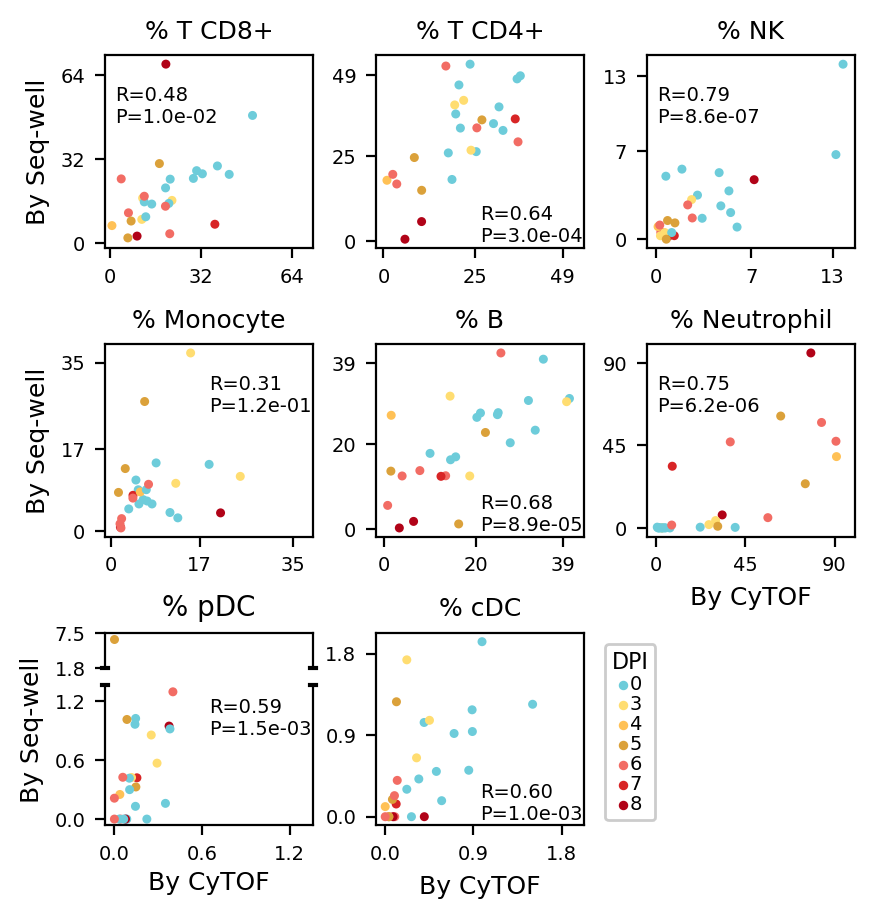

In [24]:
fig = plt.figure(figsize=(5., 5.), dpi=200)
gs = gridspec.GridSpec(3, 3, fig, left=.1, bottom=.15, top=.92,right=.85,
                       hspace=.5, wspace=.3)
axes = []
for i in range(3):
    row_axes = []
    for j in range(3):
        if ((i ==2) and (j in [0,1])) or ((i ==1) and (j ==2)):
            xlabel='By CyTOF'
        else:
            xlabel = ''

        if j == 0:
            ylabel='By Seq-well'
        else:
            ylabel = ''
        
        if (i==2) & (j==2):
            row_axes.append(None)
        elif (i==2) and (j==0):    
            outlier_spec_gs = gs[i, j].subgridspec(2, 1, hspace=0.2,
                                           height_ratios=[.2,.8])
             
            outlier_ax = fig.add_subplot(outlier_spec_gs[0],
            xscale='linear', yscale='linear', frameon=True,
            xlabel=None, ylabel=None)

            main_ax = fig.add_subplot(outlier_spec_gs[1],
                        xscale='linear', yscale='linear',
                        frameon=True, xlabel=None, ylabel=None)   

            row_axes.append(main_ax)
        else:
            ax = fig.add_subplot(gs[i, j],
                  xscale='linear', yscale='linear',
                  frameon=True, xlabel=xlabel, ylabel=ylabel)
            row_axes.append(ax)

    axes.append(row_axes)
    
axes = np.array(axes).ravel()

toplot = ['T CD8+', 'T CD4+','NK', 'Monocyte', 'B','Neutrophil', 'pDC', 'cDC']
cytofvar = 'cytof_frac'
seqwellvar = 'seqwell_frac'
cvar = 'DPIc_color'

for (i,c) in enumerate(toplot):
    if c == 'pDC':
        outlier_ind = (merged_seqwell_cytof['cell_type']==c) & (merged_seqwell_cytof['cytof_count']>100) & (merged_seqwell_cytof['seqwell_count']>100) & (merged_seqwell_cytof['samp2']=='NHP18.D005')    
        outlier_ax.set_ylim([1.8, 6])  # outliers only
        outlier_ax.scatter(merged_seqwell_cytof.loc[outlier_ind, cytofvar]*100, merged_seqwell_cytof.loc[outlier_ind, seqwellvar]*100,
                    s=5, zorder=2, c=merged_seqwell_cytof.loc[outlier_ind, cvar])
        outlier_ax.grid(False)        

        ind = (merged_seqwell_cytof['cell_type']==c) & (merged_seqwell_cytof['cytof_count']>100) & (merged_seqwell_cytof['seqwell_count']>100) & (merged_seqwell_cytof['samp2']!='NHP18.D005')        
        axes[i].scatter(merged_seqwell_cytof.loc[ind, cytofvar]*100, merged_seqwell_cytof.loc[ind, seqwellvar]*100,
                    s=5, zorder=2, c=merged_seqwell_cytof.loc[ind, cvar])
        axes[i].grid(False)
        outlier_ax.set_title('% ' + ('%s' % c), fontsize=10)
        
        
        outlier_ax.spines['bottom'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
        outlier_ax.set_xticks([])
        outlier_ax.set_ylim([1.8, 7.5])  # outliers only
        outlier_ax.set_yticks([1.8, 7.5])  # outliers only

        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=outlier_ax.transAxes, color='k', clip_on=False)
        outlier_ax.plot((-d, +d), (0, 0), **kwargs)        # top-left diagonal
        outlier_ax.plot((1 - d, 1 + d), (0, 0), **kwargs)  # top-right diagonal

        kwargs.update(transform=axes[i].transAxes)  # switch to the bottom axes
        axes[i].plot((-d, +d), (1, 1 ), **kwargs)  # bottom-left diagonal
        axes[i].plot((1 - d, 1 + d), (1, 1), **kwargs)  # bottom-right diagonal


    else:
        ind = (merged_seqwell_cytof['cell_type']==c) & (merged_seqwell_cytof['cytof_count']>100) & (merged_seqwell_cytof['seqwell_count']>100)    
        
        axes[i].scatter(merged_seqwell_cytof.loc[ind, cytofvar]*100, merged_seqwell_cytof.loc[ind, seqwellvar]*100,
                    s=5, zorder=2, c=merged_seqwell_cytof.loc[ind, cvar])
        axes[i].set_title('% ' + ('%s' % c), fontsize=9)
    
    
    (R,P) = pearsonr(merged_seqwell_cytof.loc[ind, cytofvar], merged_seqwell_cytof.loc[ind, seqwellvar])
    if c in ['T CD4+', 'B', 'cDC']:
        axes[i].text(.5, .03, 'R=%.2f\nP=%.1e' % (R,P), transform=axes[i].transAxes, fontsize=7)
    elif c in ['T CD8+','Neutrophil', 'NK']:
        axes[i].text(.05, .65, 'R=%.2f\nP=%.1e' % (R,P), transform=axes[i].transAxes, fontsize=7)
    elif c in ['Monocyte', 'pDC']:
        axes[i].text(.5, .65, 'R=%.2f\nP=%.1e' % (R,P), transform=axes[i].transAxes, fontsize=7)
    

    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    minv = min(xlim[0], ylim[0])
    maxv = max(xlim[1], ylim[1])
    axes[i].set_xlim([minv, maxv])
    axes[i].set_ylim([minv, maxv])
    
    if c not in ['pDC', 'cDC']:
        xvals = [np.round(x) for x in [0, maxv*.45, maxv*.9]]
        axes[i].set_xticks(xvals)
        axes[i].set_xticklabels([str(int(x)) for x in xvals], fontsize=7)
        yvals = xvals
        axes[i].set_yticks(yvals)
        axes[i].set_yticklabels([str(int(x)) for x in yvals], fontsize=7)
        axes[i].grid(False)
    else:
        xvals = [np.round(x, decimals=1) for x in [0, maxv*.45, maxv*.9]]
        axes[i].set_xticks(xvals)
        axes[i].set_xticklabels(['%.1f' % x for x in xvals], fontsize=7)        
        yvals = xvals
        axes[i].set_yticks(yvals)
        axes[i].set_yticklabels(['%.1f' % y for y in yvals], fontsize=7)
        axes[i].grid(False)
 

    if c == 'pDC':        
        outlier_ax.set_xlim([minv, maxv])

        
    
    
    
    
leg_ax = fig.add_axes([.6,.08,.15,.25], xticks=[], yticks=[],
                      xlim=[0,1], ylim=[0,1], frameon=False)

loc=(0,.3); framealpha=1
for i in [0, 3, 4, 5, 6, 7, 8]:
    leg_ax.scatter([], [], color=dpimap[i], label=i)

leg_ax.legend(loc=loc, fontsize=7, markerscale=.4, ncol=1,
               labelspacing=.05, columnspacing=.13, handletextpad=.1,
               title='DPI', title_fontsize=8, borderpad=.35,
              framealpha=framealpha)


combined_ax = fig.add_subplot(outlier_spec_gs[:],
        xscale='linear', yscale='linear',
        frameon=False, xticks=[], yticks=[],
        xlabel=None, ylabel=None)

combined_ax.text(.5, -0.3, 'By CyTOF', va='center', ha='center', fontsize=9)
combined_ax.text(-0.35, .5, 'By Seq-well', va='center', ha='center', fontsize=9, rotation=90)

figure_file = os.path.join(results_dir, "CelltypePercentage.CyTOFvsSeqwell.Scatter.pdf")
fig.savefig(figure_file)

## Estimate absolute counts based on CyTOF and CBC

In [25]:
cbc_fn = '../../../../data/InVivo/Cytof/SerialSac_CBC_DifferentialWhiteCount_1e3perUL_fixDays_fixID.tsv'
absolute_counts_cbc = pd.read_csv(cbc_fn, sep='\t')
absolute_counts_cbc = absolute_counts_cbc.rename(columns={'Cell_Type':'celltype_broad'})
absolute_counts_cbc['sample'] = absolute_counts_cbc['Animal'] + '.D' + absolute_counts_cbc['DPI'].astype(str).apply(lambda x: x.zfill(3))
absolute_counts_cbc.head()

,Animal,Absolute_Count_Broad_Celltype,celltype_broad,DPI,sample
0,NHPC1,0.01,Basophil,-21,NHPC1.D-21
1,NHPC2,0.02,Basophil,-30,NHPC2.D-30
2,NHPC3,0.01,Basophil,-30,NHPC3.D-30
3,NHP01,0.01,Basophil,-30,NHP01.D-30
4,NHP02,0.01,Basophil,-30,NHP02.D-30


In [26]:
lymphocyte_frac = counts_cytof.loc[['B', 'NK', 'T CD4+', 'T CD8+'], :]
lymphocyte_frac = lymphocyte_frac.div(lymphocyte_frac.sum(axis=0), axis=1)
lymphocyte_frac_flat = lymphocyte_frac.unstack().reset_index()
lymphocyte_frac_flat['Animal'] = lymphocyte_frac_flat['sample'].apply(lambda x: x.split('.')[0])
lymphocyte_frac_flat['DPI'] = lymphocyte_frac_flat['sample'].apply(lambda x: x.split('.')[1][1:]).astype(int)
lymphocyte_frac_flat = lymphocyte_frac_flat.rename(columns={'Subclustering_clean':'celltype', 0:'Differential_Frac'})
lymphocyte_frac_flat['celltype_broad'] = 'Lymphocyte'
lymphocyte_frac_flat.head()

,sample,celltype,Differential_Frac,Animal,DPI,celltype_broad
0,NHP07.D-04,B,0.180840,NHP07,-4,Lymphocyte
1,NHP07.D-04,NK,0.117115,NHP07,-4,Lymphocyte
2,NHP07.D-04,T CD4+,0.320990,NHP07,-4,Lymphocyte
3,NHP07.D-04,T CD8+,0.381055,NHP07,-4,Lymphocyte
4,NHP07.D-14,B,0.261386,NHP07,-14,Lymphocyte


In [27]:
set(lymphocyte_frac_flat['sample']) - set(absolute_counts_cbc['sample'])

{'NHP18.D003', 'NHPC2.D-02', 'NHPC3.D-02'}

In [28]:
set(absolute_counts_cbc['sample']) - set(lymphocyte_frac_flat['sample'])

{'NHP01.D-30',
 'NHP01.D000',
 'NHP01.D006',
 'NHP02.D-30',
 'NHP02.D000',
 'NHP02.D007',
 'NHP03.D-30',
 'NHP03.D000',
 'NHP03.D008',
 'NHP04.D-30',
 'NHP04.D000',
 'NHP04.D007',
 'NHP05.D-30',
 'NHP05.D000',
 'NHP05.D005',
 'NHP06.D-30',
 'NHP06.D000',
 'NHP06.D008',
 'NHPC2.D-30',
 'NHPC3.D-30'}

In [29]:
absolute_counts_cbc_merge = pd.merge(left=absolute_counts_cbc, right=lymphocyte_frac_flat[['Animal', 'DPI', 'celltype', 'Differential_Frac', 'celltype_broad']],
                                     on=['Animal', 'DPI', 'celltype_broad'], how='left')
absolute_counts_cbc_merge.head()

,Animal,Absolute_Count_Broad_Celltype,celltype_broad,DPI,sample,celltype,Differential_Frac
0,NHPC1,0.01,Basophil,-21,NHPC1.D-21,NaN,NaN
1,NHPC2,0.02,Basophil,-30,NHPC2.D-30,NaN,NaN
2,NHPC3,0.01,Basophil,-30,NHPC3.D-30,NaN,NaN
3,NHP01,0.01,Basophil,-30,NHP01.D-30,NaN,NaN
4,NHP02,0.01,Basophil,-30,NHP02.D-30,NaN,NaN


In [30]:
absolute_counts_cbc_merge.loc[absolute_counts_cbc_merge['celltype_broad']=='Lymphocyte',:]

,Animal,Absolute_Count_Broad_Celltype,celltype_broad,DPI,sample,celltype,Differential_Frac
214,NHPC1,2.87,Lymphocyte,-21,NHPC1.D-21,B,0.380805
215,NHPC1,2.87,Lymphocyte,-21,NHPC1.D-21,NK,0.021478
216,NHPC1,2.87,Lymphocyte,-21,NHPC1.D-21,T CD4+,0.337461
217,NHPC1,2.87,Lymphocyte,-21,NHPC1.D-21,T CD8+,0.260255
218,NHPC2,1.93,Lymphocyte,-30,NHPC2.D-30,NaN,NaN
...,...,...,...,...,...,...,...
577,NHP09,1.43,Lymphocyte,8,NHP09.D008,T CD8+,0.480765
578,NHP12,3.93,Lymphocyte,8,NHP12.D008,B,0.148919
579,NHP12,3.93,Lymphocyte,8,NHP12.D008,NK,0.165001
580,NHP12,3.93,Lymphocyte,8,NHP12.D008,T CD4+,0.238048


In [31]:
ind = ~absolute_counts_cbc_merge['celltype_broad'].isin(['Lymphocyte'])
absolute_counts_cbc_merge.loc[ind,'Differential_Frac'] = 1
absolute_counts_cbc_merge.loc[ind,'celltype'] = absolute_counts_cbc_merge.loc[ind,'celltype_broad']
absolute_counts_cbc_merge['Estimated_abundance_diff'] = absolute_counts_cbc_merge['Absolute_Count_Broad_Celltype'] * absolute_counts_cbc_merge['Differential_Frac']
absolute_counts_cbc_merge['DPIc'] = absolute_counts_cbc_merge['DPI'].copy()
absolute_counts_cbc_merge.loc[absolute_counts_cbc_merge['DPIc']<0, 'DPIc'] = 0
absolute_counts_cbc_merge.head()

,Animal,Absolute_Count_Broad_Celltype,celltype_broad,DPI,sample,celltype,Differential_Frac,Estimated_abundance_diff,DPIc
0,NHPC1,0.01,Basophil,-21,NHPC1.D-21,Basophil,1.0,0.01,0
1,NHPC2,0.02,Basophil,-30,NHPC2.D-30,Basophil,1.0,0.02,0
2,NHPC3,0.01,Basophil,-30,NHPC3.D-30,Basophil,1.0,0.01,0
3,NHP01,0.01,Basophil,-30,NHP01.D-30,Basophil,1.0,0.01,0
4,NHP02,0.01,Basophil,-30,NHP02.D-30,Basophil,1.0,0.01,0


In [32]:
absolute_counts_cbc_merge_reduced = absolute_counts_cbc_merge.groupby(['Animal', 'DPIc', 'celltype']).mean().reset_index()

In [33]:
absolute_counts_cbc_merge_reduced.head()

,Animal,DPIc,celltype,Absolute_Count_Broad_Celltype,DPI,Differential_Frac,Estimated_abundance_diff
0,NHP01,0,Basophil,0.010,-15,1.0,0.010
1,NHP01,0,Eosinophil,0.025,-15,1.0,0.025
2,NHP01,0,Monocyte,0.290,-15,1.0,0.290
3,NHP01,0,Neutrophil,7.545,-15,1.0,7.545
4,NHP01,6,Basophil,0.020,6,1.0,0.020


In [34]:
abundance_peranimal = absolute_counts_cbc_merge.pivot_table(index='Animal', columns=('celltype', 'DPIc'), values='Estimated_abundance_diff')
abundance_peranimal.head()

celltype   B                                 Basophil  ... T CD4+ T CD8+      \
DPIc       0   1   2   3   4   5   6   7   8        0  ...      8      0   1   
Animal                                                 ...                     
NHP01    NaN NaN NaN NaN NaN NaN NaN NaN NaN    0.010  ...    NaN    NaN NaN   
NHP02    NaN NaN NaN NaN NaN NaN NaN NaN NaN    0.010  ...    NaN    NaN NaN   
NHP03    NaN NaN NaN NaN NaN NaN NaN NaN NaN    0.015  ...    NaN    NaN NaN   
NHP04    NaN NaN NaN NaN NaN NaN NaN NaN NaN    0.010  ...    NaN    NaN NaN   
NHP05    NaN NaN NaN NaN NaN NaN NaN NaN NaN    0.015  ...    NaN    NaN NaN   

celltype                              
DPIc       2   3   4   5   6   7   8  
Animal                                
NHP01    NaN NaN NaN NaN NaN NaN NaN  
NHP02    NaN NaN NaN NaN NaN NaN NaN  
NHP03    NaN NaN NaN NaN NaN NaN NaN  
NHP04    NaN NaN NaN NaN NaN NaN NaN  
NHP05    NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 72 columns]

In [35]:

P = pd.Series(np.nan, index=abundance_peranimal.columns)
for c in abundance_peranimal.columns:
    if c[1] != 0:
        test = abundance_peranimal[c]
        base = abundance_peranimal[(c[0], 0)]
        ind = ~test.isnull() & ~base.isnull()
        test = test.loc[ind]
        base = base.loc[ind]
        P.loc[c] = wilcoxon(base, test).pvalue
    
    
P.loc['Neutrophil']
P.loc['T CD4+']
P.loc['T CD8+']
P.loc['NK']
P.loc['B']

P.loc[['Neutrophil', 'T CD4+', 'T CD8+', 'NK', 'B']]


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


celltype    DPIc
B           0            NaN
            1       0.600179
            2       0.753152
            3       0.032854
            4       0.027708
            5       0.020879
            6       0.043114
            7       0.179712
            8       0.654721
NK          0            NaN
            1       0.463071
            2       0.248864
            3       0.003346
            4       0.046399
            5       0.010862
            6       0.043114
            7       0.179712
            8       0.654721
Neutrophil  0            NaN
            1       0.463071
            2       0.248864
            3       0.004439
            4       0.027708
            5       0.059336
            6       0.600179
            7       0.715001
            8       0.465209
T CD4+      0            NaN
            1       0.753152
            2       0.753152
            3       0.005847
            4       0.027708
            5       0.313938
            6       0.0431

In [36]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .2
right_space = .98
bottom_space = .17
top_space = .98

c = palettable.tableau.Tableau_20.hex_colors
ctcmap = {'B':c[0], 'T CD8+':c[3], 'T CD4+':c[2], 'NK':c[6], 'Monocyte':c[4], 'Neutrophil':c[8]}
renmap = {'B':'B', 'T CD8+':'T CD8+', 'T CD4+':'T CD4+', 'NK':'NK', 'Monocyte':'Mono.', 'Neutrophil':'Neut.'}

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


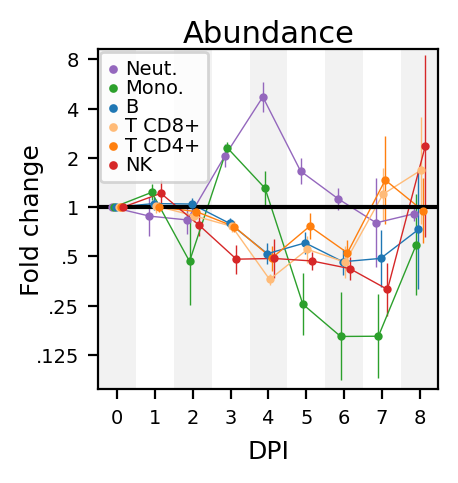

In [37]:
ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(2, 1, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[],yticks=[],
          xlim=[0,1],
          ylim=[0,1])
title_ax.text(0.50, 1.0, 'Abundance', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

order = ['Neutrophil', 'Monocyte', 'B', 'T CD8+', 'T CD4+','NK']

offset=.05
shift = np.linspace(offset*-3, offset*3, len(order))
markersize=2
for (i,ct) in enumerate(order):
    ctdat = abundance_peranimal[ct].copy()
    ctdat = ctdat+.01
    ratio = ctdat.div(ctdat[0], axis=0)
    ratio_log2 = ratio.apply(np.log2)
    ratio_log2_mean = ratio_log2.mean(axis=0)
    ratio_log2_se = ratio_log2.sem(axis=0)
    
    ax.plot(ratio_log2_mean.index+shift[i], ratio_log2_mean.values, color=ctcmap[ct], linewidth=.5, label=None)
    ax.scatter(ratio_log2_mean.index+shift[i], ratio_log2_mean.values, color=ctcmap[ct], s=markersize, label=renmap[ct])

    ax.errorbar(ratio_log2_mean.index+shift[i], ratio_log2_mean.values, yerr=ratio_log2_se.values, color=ctcmap[ct], fmt='o',
                markersize=markersize, elinewidth=.5, label=None)
    

xlim = ax.get_xlim()
ax.plot(xlim, [0,0], color='k')
ax.set_xlim(xlim)
ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
ax.set_yticklabels(['.125', '.25', '.5', '1', '2', '4', '8'])
ax.set_ylabel('Fold change', labelpad=-3)
ax.set_xticks(np.arange(9))
ax.set_xticklabels([str(x) for x in range(9)])
ax.set_xlabel('DPI')
ax.grid(False)

leg = ax.legend(loc=(0.005,.61), fontsize=7, markerscale=1.5,
                labelspacing=0.01)

for line in leg.get_lines():
    line.set_linewidth(2.0)

x_width=1
ylim = [-3.7, 3.2]
for i in range(9):
  if (i % 2)==0:
    ax.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=ylim[1], facecolor='gray', alpha=0.1)

ax.set_ylim(ylim)

ax.set_xlim([-.5,8.5])

figure_file = os.path.join(results_dir, "InVivoComposition.TimeCourse.Summary.pdf")
fig.savefig(figure_file)

In [38]:
abundance_peranimal

celltype         B                                                    \
DPIc             0         1         2         3         4         5   
Animal                                                                 
NHP01          NaN       NaN       NaN       NaN       NaN       NaN   
NHP02          NaN       NaN       NaN       NaN       NaN       NaN   
NHP03          NaN       NaN       NaN       NaN       NaN       NaN   
NHP04          NaN       NaN       NaN       NaN       NaN       NaN   
NHP05          NaN       NaN       NaN       NaN       NaN       NaN   
NHP06          NaN       NaN       NaN       NaN       NaN       NaN   
NHP07     0.335559       NaN       NaN  0.298652       NaN  0.402434   
NHP08     0.993903       NaN       NaN  0.811473       NaN  0.346161   
NHP09     0.809819       NaN       NaN  0.815740       NaN  0.418830   
NHP10     0.635443       NaN       NaN  0.635247       NaN  0.387908   
NHP11     0.645976       NaN       NaN  0.403952       NaN  0.330494   
NHP12     0.342566       NaN       NaN  0.348491       NaN  0.166340   
NHP13     1.152565  0.867325       NaN  0.567434       NaN       NaN   
NHP14     0.688343  0.722571       NaN  0.447380       NaN       NaN   
NHP15     0.681999  0.810938       NaN  0.409102       NaN       NaN   
NHP16     0.767894  1.067691       NaN  0.643260       NaN  0.316027   
NHP17     0.107432  0.124052       NaN  0.111898       NaN  0.154012   
NHP18     0.958199  0.871551       NaN       NaN       NaN  0.494036   
NHP19     2.420354       NaN  2.392621       NaN  0.693482       NaN   
NHP20     0.614542       NaN  0.599943       NaN  0.414900       NaN   
NHP21     0.485686       NaN  0.534140       NaN  0.327483       NaN   
NHP22     0.560753       NaN  0.455741       NaN  0.206287       NaN   
NHP23     0.866059       NaN  0.883282       NaN  0.463452       NaN   
NHP24     0.436131       NaN  0.646850       NaN  0.309605       NaN   
NHPC1     1.092920       NaN       NaN       NaN       NaN       NaN   
NHPC2     0.781723       NaN       NaN       NaN       NaN       NaN   
NHPC3     2.043851       NaN       NaN       NaN       NaN       NaN   

celltype                               Basophil  ...    T CD4+    T CD8+  \
DPIc             6         7         8        0  ...         8         0   
Animal                                           ...                       
NHP01          NaN       NaN       NaN    0.010  ...       NaN       NaN   
NHP02          NaN       NaN       NaN    0.010  ...       NaN       NaN   
NHP03          NaN       NaN       NaN    0.015  ...       NaN       NaN   
NHP04          NaN       NaN       NaN    0.010  ...       NaN       NaN   
NHP05          NaN       NaN       NaN    0.015  ...       NaN       NaN   
NHP06          NaN       NaN       NaN    0.005  ...       NaN       NaN   
NHP07          NaN  0.239561       NaN    0.015  ...       NaN  0.536969   
NHP08     0.487201       NaN       NaN    0.015  ...       NaN  1.394369   
NHP09          NaN       NaN  0.249021    0.010  ...  0.427079  0.869904   
NHP10          NaN  0.201302       NaN    0.000  ...       NaN  0.721121   
NHP11     0.297897       NaN       NaN    0.010  ...       NaN  1.903682   
NHP12          NaN       NaN  0.585253    0.010  ...  0.935528  0.487732   
NHP13          NaN       NaN       NaN    0.010  ...       NaN  0.700456   
NHP14          NaN       NaN       NaN    0.010  ...       NaN  0.480171   
NHP15          NaN       NaN       NaN    0.030  ...       NaN  0.398932   
NHP16          NaN       NaN       NaN    0.035  ...       NaN  0.482006   
NHP17          NaN       NaN       NaN    0.005  ...       NaN  0.323974   
NHP18          NaN       NaN       NaN    0.005  ...       NaN  0.355195   
NHP19          NaN       NaN       NaN    0.020  ...       NaN  1.013232   
NHP20          NaN       NaN       NaN    0.015  ...       NaN  0.894504   
NHP21          NaN       NaN       NaN    0.025  ...       NaN  0.705634   
NHP22     0.144

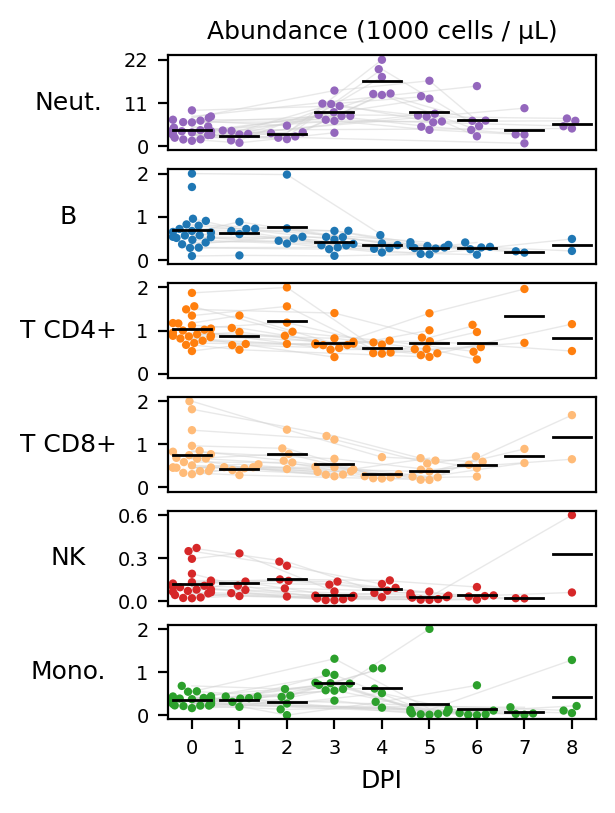

In [39]:
order = ['Neutrophil', 'B', 'T CD4+', 'T CD8+','NK',  'Monocyte']
renamed = ['Neut.', 'B', 'T CD4+', 'T CD8+', 'NK', 'Mono.']
rename_map = dict(zip(order, renamed))

fig = plt.figure(figsize=(3, 4), dpi=200)
gs = gridspec.GridSpec(len(order), 2, fig, left=0., bottom=.1, right=.95,top=.93,
                       hspace=0.2, wspace=0, width_ratios=(.25, .75))
axes = []
mean_bar_width = .8
for (i,ct) in enumerate(order):
    ax = fig.add_subplot(gs[i, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel=ct, xlabel='',
          xticks=[],
          xlim=[-1, 9] )
    axes.append(ax)

    X = absolute_counts_cbc_merge_reduced.loc[absolute_counts_cbc_merge_reduced['celltype']==ct,:]    
    Xpivot = X.pivot(index='Animal', columns='DPIc', values='Estimated_abundance_diff')
    
    ymax = X['Estimated_abundance_diff'].max()
    ax.set_ylim([0-ymax*.05, ymax*1.05])
    ax.set_yticks([0, ymax/2, ymax])
    if ymax<1:
        ax.set_yticklabels(['%.1f' % x for x in [0, ymax/2, ymax]], fontsize=7)
    else:
        ax.set_yticklabels(['%.0f' % x for x in [0, ymax/2, ymax]], fontsize=7)    
        
    for a in Xpivot.index:
        dat = Xpivot.loc[a,:].dropna()
        ax.plot(dat.index, dat.values, color='lightgray', linewidth=.5, alpha=.5, zorder=0)
    
    sns.swarmplot(x='DPIc', y='Estimated_abundance_diff', data=X, ax=ax, s=3, zorder=1, color=ctcmap[ct])
    ax.set_ylabel('')
    ax.set_xlabel('')

    mean = Xpivot.mean(axis=0)
    for d in Xpivot.columns:
      ax.plot([d-.5*mean_bar_width, d+.5*mean_bar_width], [mean.loc[d], mean.loc[d]],
              color='k', linewidth=1)
    
    ax.set_title('', pad=4)
    #ax.set_ylabel(rename_map[ct], fontsize=7, rotation=1)


    lab_ax = fig.add_subplot(gs[i, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          xticks=[],yticks=[],
          xlim=[0,1] )
    
    lab_ax.text(0.3, 0.5, s=rename_map[ct], fontsize=9, va='center', ha='center')

    if i != (len(order)-1):
        ax.set_xlabel('')
        ax.set_xticks([])
    else:
      ax.set_xticklabels(np.arange(0,9), fontsize=7)
    
    ax.grid(False)
    
axes[-1].set_xlabel('DPI', fontsize=9)
axes[0].set_title('Abundance (1000 cells / µL)')

figure_file = os.path.join(results_dir, "InVivoComposition.TimeCourseAll.Swarmplot.pdf")
fig.savefig(figure_file)

## Proliferation analysis

In [40]:
Ki67_thresh = 1.8

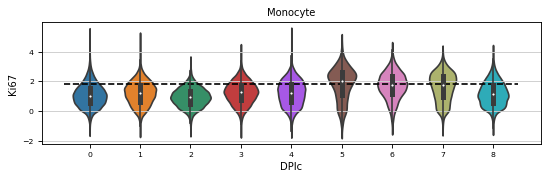

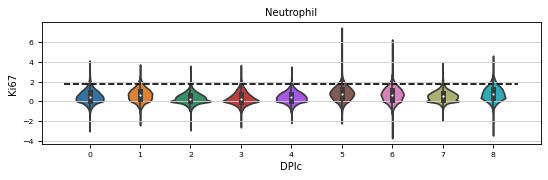

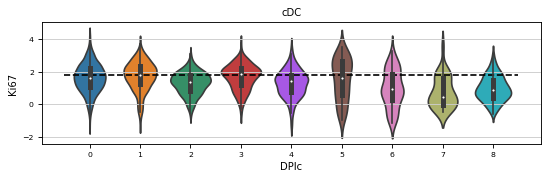

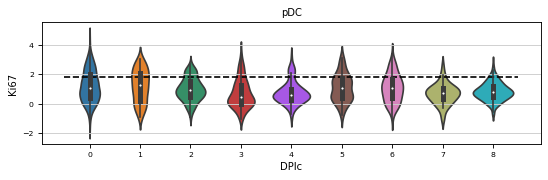

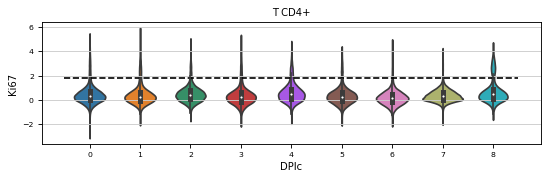

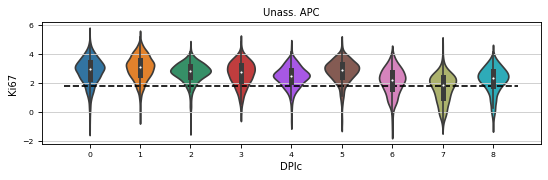

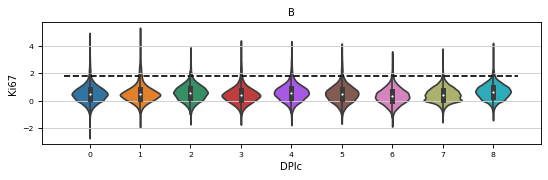

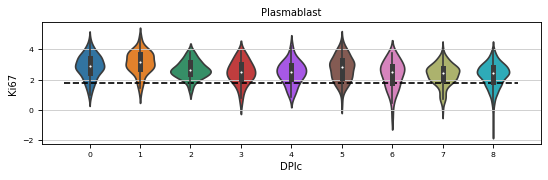

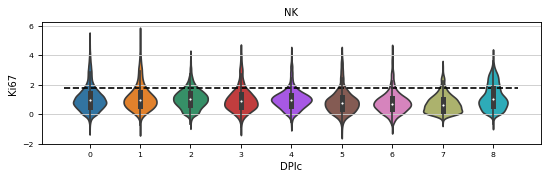

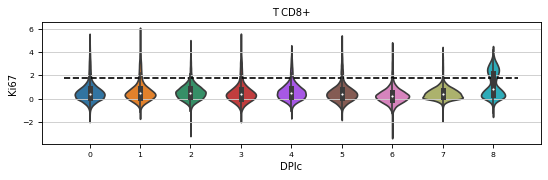

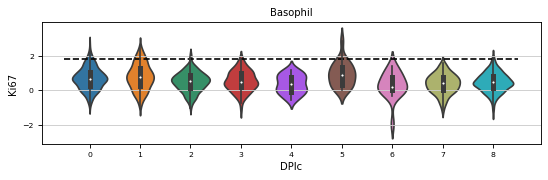

In [41]:
### Cytof

for ct in cytof['Subclustering_clean'].unique():
    ind = cytof['Subclustering_clean'] == ct
    (fig,ax) = plt.subplots(1,1, figsize=(8,2))
    ax = sns.violinplot(y='Ki67', x='DPIc', data=cytof.loc[ind,:], ax=ax)
    ax.set_title(ct)
    xlim = ax.get_xlim()
    ax.hlines(y=Ki67_thresh, xmin=xlim[0], xmax=xlim[1], linestyle='--')

In [42]:
cytof.columns

Index(['DPI', 'DPIc', 'Multiplex_Barcode', 'Multiplex_Group', 'Period',
       'animal', 'clinical_score', 'context', 'intensity_sum', 'is_doublet',
       'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes',
       'samp', 'sample', 'sum_intensity', 'Subclustering', 'leiden14',
       'leiden13', 'SubclusteringGroup', 'Subclustering_reduced', 'UMAP_1',
       'UMAP_2', 'Subclustering_clean', 'dpi_color', 'cluster_color',
       'Multiplex_Group_Num', 'Multiplex_Group_Color', 'Ki67', 'CD38',
       'HLA-DR', 'CD14', 'CD16'],
      dtype='object')

In [43]:
frac_ki67_cytof = cytof.groupby(['animal', 'DPIc', 'Subclustering_reduced'])['Ki67'].agg(lambda x: (x>1.8).mean()).reset_index()
frac_ki67_cytof['Ki67']*=100
frac_ki67_cytof_tab = frac_ki67_cytof.pivot_table(index=('Subclustering_reduced', 'animal'), columns='DPIc', values='Ki67')
#frac_ki67_cytof_tab *=100
frac_ki67_cytof.head()

,animal,DPIc,Subclustering_reduced,Ki67
0,NHP07,0,B,2.518187
1,NHP07,0,Basophil,0.000000
2,NHP07,0,Mono,11.375555
3,NHP07,0,NK,21.857143
4,NHP07,0,Neut,3.270224


In [44]:
frac_ki67_cytof_tab.head()

DPIc                                 0   1   2         3   4         5  \
Subclustering_reduced animal                                             
B                     NHP07   2.518187 NaN NaN  2.979738 NaN  1.897019   
                      NHP08   2.670318 NaN NaN  2.033037 NaN  4.993598   
                      NHP09   1.943844 NaN NaN  1.814798 NaN  2.091860   
                      NHP10   1.937984 NaN NaN  2.252747 NaN  3.044754   
                      NHP11   1.651572 NaN NaN  0.688863 NaN  1.086048   

DPIc                                 6         7         8  
Subclustering_reduced animal                                
B                     NHP07        NaN  0.460224       NaN  
                      NHP08   1.961459       NaN       NaN  
                      NHP09        NaN       NaN  1.176471  
                      NHP10        NaN  1.409052       NaN  
                      NHP11   1.672241       NaN       NaN

In [45]:
frac_ki67_cytof_tab.groupby('Subclustering_reduced').mean()

DPIc,0,1,2,3,4,5,6,7,8
Subclustering_reduced,,,,,,,,,
B,3.079857,5.110900,2.425132,3.285496,2.474338,2.939191,1.291438,0.934638,1.938142
Basophil,2.671876,10.987481,3.329800,1.298701,0.000000,2.083333,0.000000,0.000000,1.872185
Mono,17.704697,22.169979,7.598321,23.561680,28.812239,56.476715,44.203577,44.315277,42.357045
NK,14.190751,16.375758,12.087931,10.472107,11.077143,9.289520,11.381249,5.568962,31.798884
Neut,3.429895,4.187247,2.267678,2.601085,0.974612,6.949240,7.817963,3.200883,8.090784
Plasmablast,89.288944,90.416667,87.500000,84.642857,76.464646,84.671717,55.411255,70.825516,66.752336
Tc,7.087167,9.871442,4.077403,7.015445,8.851608,5.871618,3.423908,2.701481,37.287958
Th,5.667784,7.641071,4.305269,5.589559,9.359235,4.105007,1.701994,1.564342,16.930546
Unassigned_APC,86.575458,89.525161,90.059005,81.489700,75.194214,88.158432,56.729055,51.688495,73.290043


[0, 70]
[0, 70]
[0, 70]
[0, 70]
[0, 70]


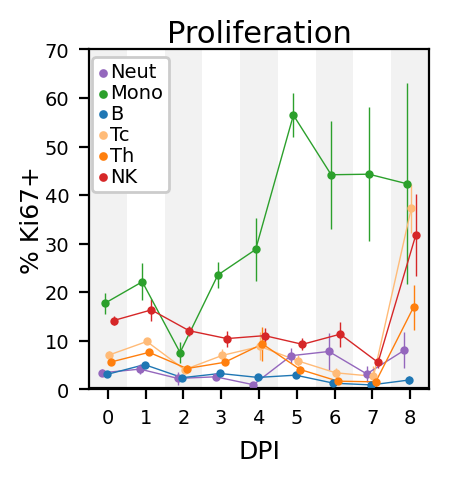

In [47]:
c = palettable.tableau.Tableau_20.hex_colors
ctcmap3 = {'B':c[0], 'Tc':c[3], 'Th':c[2], 'NK':c[6], 'Mono':c[4], 'Neut':c[8]}


box_height=1.7
box_width=1.7
title_height=.15
left_space = .17
right_space = .98
bottom_space = .15
top_space = .98

#abundance_peranimal.columns = pd.MultiIndex.from_tuples(newcols)

ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(2, 1, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[],yticks=[],
          xlim=[0,1],
          ylim=[0,1])
title_ax.text(0.50, 1.0, 'Proliferation', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)


order = ['Neut', 'Mono', 'B', 'Tc', 'Th','NK']

offset=.05
shift = np.linspace(offset*-3, offset*3, len(order))
markersize=2
for (i,ct) in enumerate(order):
    frac_mean = frac_ki67_cytof_tab.loc[ct,:].mean(axis=0)
    frac_sem = frac_ki67_cytof_tab.loc[ct,:].sem(axis=0)
    
    
    ax.plot(frac_mean.index+shift[i], frac_mean.values, color=ctcmap3[ct], linewidth=.5, label=None)
    ax.scatter(frac_mean.index+shift[i], frac_mean.values, color=ctcmap3[ct], s=markersize, label=ct)

    ax.errorbar(frac_mean.index+shift[i], frac_mean.values, yerr=frac_sem.values, color=ctcmap3[ct], fmt='o',
                markersize=markersize, elinewidth=.5, label=None)
    



xlim = ax.get_xlim()
ax.plot(xlim, [0,0], color='k')
ax.set_xlim(xlim)
#ax.set_yticks([0, .2, .4, .6])
#ax.set_yticklabels(['0', '.2', '.4', '.6'])
ax.set_ylabel('% Ki67+', labelpad=0.3)

ax.set_xticks(np.arange(9))
ax.set_xticklabels([str(x) for x in range(9)])
ax.set_xlabel('DPI')
ax.grid(False)
leg = ax.legend(loc=(0.01,.58), fontsize=7, markerscale=1.5,
                labelspacing=0.1, borderpad=0.3, handletextpad=0.1,
                framealpha=1)
for line in leg.get_lines():
    line.set_linewidth(2.0)

x_width=1
ylim = [0, 70]
ax.set_ylim(ylim)
for i in range(9):
  if (i % 2)==0:
    print(ylim)
    ax.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=1, facecolor='gray', alpha=0.1)

ax.set_xlim([-.5,8.5])

figure_file = os.path.join(results_dir, "InVivoReplication.TimeCourse.Summary.pdf")
fig.savefig(figure_file)

In [75]:
ind1 = (frac_ki67_cytof['Subclustering_reduced']=='Mono') & (frac_ki67_cytof['DPIc']==0)
ind2 = (frac_ki67_cytof['Subclustering_reduced']=='Mono') & (frac_ki67_cytof['DPIc']>=5)
ranksums(frac_ki67_cytof.loc[ind1, 'Ki67'], frac_ki67_cytof.loc[ind2, 'Ki67'])

RanksumsResult(statistic=-4.394802124588286, pvalue=1.1087370209737687e-05)

In [80]:
ind1 = (frac_ki67_cytof['Subclustering_reduced']=='Tc') & (frac_ki67_cytof['DPIc']==0)
ind2 = (frac_ki67_cytof['Subclustering_reduced']=='Tc') & (frac_ki67_cytof['DPIc']==8)
ranksums(frac_ki67_cytof.loc[ind1, 'Ki67'], frac_ki67_cytof.loc[ind2, 'Ki67'])

RanksumsResult(statistic=-2.29128784747792, pvalue=0.02194677100324686)

In [81]:
ind1 = (frac_ki67_cytof['Subclustering_reduced']=='Th') & (frac_ki67_cytof['DPIc']==0)
ind2 = (frac_ki67_cytof['Subclustering_reduced']=='Th') & (frac_ki67_cytof['DPIc']==8)
ranksums(frac_ki67_cytof.loc[ind1, 'Ki67'], frac_ki67_cytof.loc[ind2, 'Ki67'])

RanksumsResult(statistic=-2.29128784747792, pvalue=0.02194677100324686)

In [78]:
ind1 = (frac_ki67_cytof['Subclustering_reduced']=='NK') & (frac_ki67_cytof['DPIc']==0)
ind2 = (frac_ki67_cytof['Subclustering_reduced']=='NK') & (frac_ki67_cytof['DPIc']==8)
ranksums(frac_ki67_cytof.loc[ind1, 'Ki67'], frac_ki67_cytof.loc[ind2, 'Ki67'])

RanksumsResult(statistic=-2.29128784747792, pvalue=0.02194677100324686)

In [ ]:
frac_ki67_cytof_fortesting = frac_ki67_cytof.pivot_table(index='animal', columns=['Subclustering_reduced', 'DPIc'], values='Ki67')

P = pd.Series(np.nan, index=frac_ki67_cytof_fortesting.columns)
for c in frac_ki67_cytof_fortesting.columns:
    if c[0] in ['Basophil', 'Eosinophil']:
        continue
    if c[1] != 0:
        test = frac_ki67_cytof_fortesting[c]
        base = frac_ki67_cytof_fortesting[(c[0], 0)]
        ind = ~test.isnull() & ~base.isnull()
        test = test.loc[ind]
        base = base.loc[ind]
        #if (c[0]=='Mono') and (c[1]==6):
        #    print('here')
        #    sys.exit(-1)
        P.loc[c] = wilcoxon(base, test).pvalue


P.loc['Mono']


In [67]:
frac_ki67_cytof.head()

,animal,DPIc,Subclustering_reduced,Ki67
0,NHP07,0,B,2.518187
1,NHP07,0,Basophil,0.000000
2,NHP07,0,Mono,11.375555
3,NHP07,0,NK,21.857143
4,NHP07,0,Neut,3.270224


In [68]:
frac_ki67_cytof['Subclustering_reduced'].unique()

array(['B', 'Basophil', 'Mono', 'NK', 'Neut', 'Plasmablast', 'Tc', 'Th',
       'Unassigned_APC', 'cDC', 'pDC'], dtype=object)

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


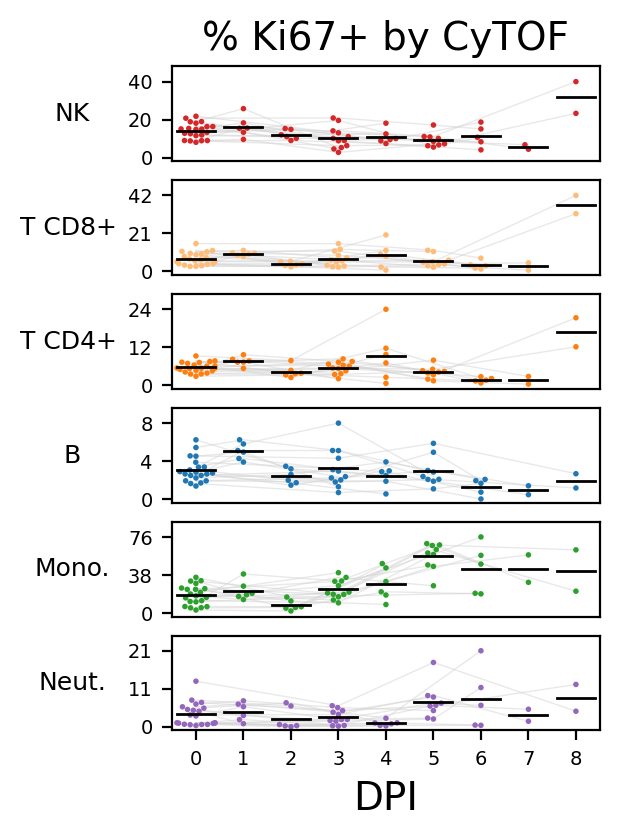

In [69]:
order = ['NK', 'Tc', 'Th', 'B', 'Mono', 'Neut']
renamed = ['NK', 'T CD8+ ','T CD4+ ', 'B', 'Mono.', 'Neut.']
rename_map = dict(zip(order, renamed))

fig = plt.figure(figsize=(3, 4), dpi=200)
gs = gridspec.GridSpec(len(order), 2, fig, left=0., bottom=.1, right=.95,top=.93,
                       hspace=0.2, wspace=0, width_ratios=(.25, .75))

axes = []
mean_bar_width = .8
for (i,ct) in enumerate(order):
    ax = fig.add_subplot(gs[i, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel=ct, xlabel='',
          xticks=[],
          xlim=[-1, 9] )
    axes.append(ax)
    
    X = frac_ki67_cytof.loc[frac_ki67_cytof['Subclustering_reduced']==ct,:]    
    Xpivot = frac_ki67_cytof_tab.loc[ct, :]
    
    ymax = X['Ki67'].max()
    ax.set_ylim([0-ymax*.05, ymax*1.2])
    ax.set_yticks([0, ymax/2, ymax])
    if ymax<1:
        ax.set_yticklabels(['%.1f' % x for x in [0, ymax/2, ymax]], fontsize=7)
    else:
        ax.set_yticklabels(['%.0f' % x for x in [0, ymax/2, ymax]], fontsize=7)    
        
    for a in Xpivot.index:
        dat = Xpivot.loc[a,:].dropna()
        ax.plot(dat.index, dat.values, color='lightgray', linewidth=.5, alpha=.5, zorder=0)
    
    sns.swarmplot(x='DPIc', y='Ki67', data=X, ax=ax, s=2, zorder=1, color=ctcmap3[ct])
    ax.set_ylabel('')
    ax.set_xlabel('')
  
    mean = Xpivot.mean(axis=0)
    for d in Xpivot.columns:
        ax.plot([d-.5*mean_bar_width, d+.5*mean_bar_width], [mean.loc[d], mean.loc[d]],
              color='k', linewidth=1)
    
    lab_ax = fig.add_subplot(gs[i, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          xticks=[],yticks=[],
          xlim=[0,1] )
    
    lab_ax.text(0.3, 0.5, s=rename_map[ct], fontsize=9, va='center', ha='center')

    if i != (len(order)-1):
        ax.set_xlabel('')
        ax.set_xticks([])
    else:
        ax.set_xticklabels(np.arange(0,9), fontsize=7)
    
    ax.grid(False)
    
axes[-1].set_xlabel('DPI')
axes[0].set_title('% Ki67+ by CyTOF')

figure_file = os.path.join(results_dir, "ReplicationRate.TimeCourseAll.CyTOF.Swarmplot.pdf")
fig.savefig(figure_file)

## Seqwell

In [51]:
adata_seqwell_fn = os.path.join(seqwell_adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.h5ad'.format(project=seqwell_project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata = read_adata(adata_seqwell_fn, gcs=False)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [52]:
adata_seqwell_raw = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata_seqwell_raw = adata_seqwell_raw[:,~adata_seqwell_raw.var['Combined_Blacklist']]
sc.pp.filter_genes(adata_seqwell_raw, min_cells=10)
sc.pp.normalize_per_cell(adata_seqwell_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_seqwell_raw)

filtered out 241 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [53]:
import magic
magic_operator = magic.MAGIC(knn_dist='cosine', t=3, random_state=14, n_jobs=7)
X_magic = magic_operator.fit_transform(adata_seqwell_raw, genes=['CD14', 'FCGR3', 'MKI67'])

Calculating MAGIC...
  Running MAGIC on 56929 cells and 16705 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 38.77 seconds.
    Calculating KNN search...
    Calculated KNN search in 146.89 seconds.
    Calculating affinities...
    Calculated affinities in 146.12 seconds.
  Calculated graph and diffusion operator in 331.94 seconds.
  Calculating imputation...
  Calculated imputation in 0.05 seconds.
Calculated MAGIC in 332.17 seconds.


/home/dkotliar/.local/lib/python3.7/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [54]:
Xseq = adata_seqwell_raw.obs.copy()

In [55]:
Xseq['MAGIC_KI67'] = X_magic.obs_vector('MKI67')

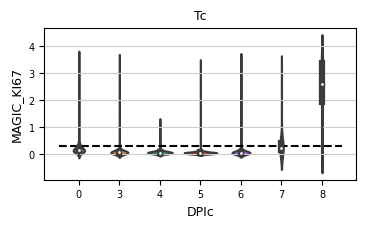

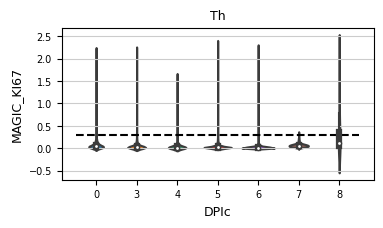

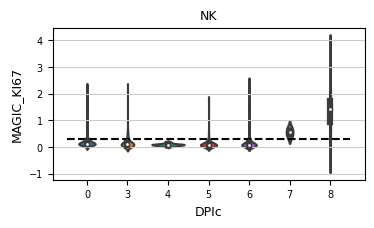

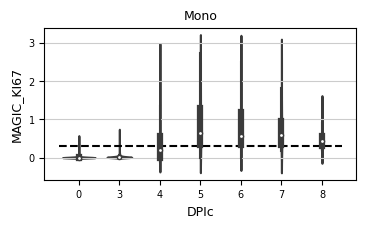

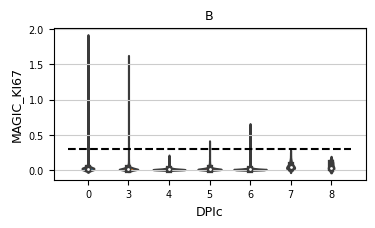

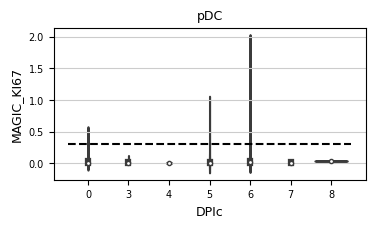

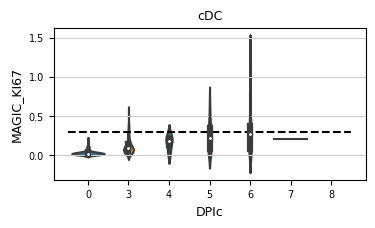

In [56]:
for ct in ['Tc', 'Th', 'NK', 'Mono', 'B', 'pDC', 'cDC']:
    (fig,ax) = plt.subplots(1,1, figsize=(4,2), dpi=100)
    ind = Xseq['Subclustering_reduced'] == ct
    sns.violinplot(x='DPIc', y='MAGIC_KI67', data=Xseq.loc[ind,:], ax=ax)
    ax.set_title(ct)
    xlim = ax.get_xlim()
    ax.hlines(y=0.3, xmin=xlim[0], xmax=xlim[1], linestyle='--')

In [57]:
#frac_cc_seq = Xseq.groupby(['animal', 'DPIc', 'Subclustering_reduced'])[['cell_cycle2', 'cell_cycle3', 'MAGIC_Ki67', 'MAGIC_TOP2A']].agg(lambda x: (x>0.1).mean()).reset_index()
#count_cc_seq = Xseq.groupby(['animal', 'DPIc', 'Subclustering_reduced'])['cell_cycle2'].count().reset_index().rename(columns={'cell_cycle2':'count'})

#frac_cc_seq = Xseq.groupby(['animal', 'DPIc', 'Subclustering_reduced'])[['ccscore']].agg(lambda x: (x>0.1).mean()).reset_index()
#count_cc_seq = Xseq.groupby(['animal', 'DPIc', 'Subclustering_reduced'])['ccscore'].count().reset_index().rename(columns={'ccscore':'count'})

frac_cc_seq = Xseq.groupby(['animal', 'DPIc', 'Subclustering_reduced'])[['MAGIC_KI67']].agg(lambda x: 100*(x>0.3).mean()).reset_index()
count_cc_seq = Xseq.groupby(['animal', 'DPIc', 'Subclustering_reduced'])['MAGIC_KI67'].count().reset_index().rename(columns={'MAGIC_KI67':'count'})

frac_cc_seq = pd.merge(left=frac_cc_seq, right=count_cc_seq, on=['animal', 'DPIc', 'Subclustering_reduced'], how='left')
frac_cc_seq['DPIc'] = frac_cc_seq['DPIc'].astype(int)
frac_cc_seq.head()

,animal,DPIc,Subclustering_reduced,MAGIC_KI67,count
0,NHP08,0,B,0.000000,255
1,NHP08,0,Mono,0.000000,43
2,NHP08,0,NK,7.692307,52
3,NHP08,0,Neut,0.000000,4
4,NHP08,0,Plasmablast,NaN,0


In [58]:
cyt_seq_merge = pd.merge(left=frac_cc_seq, right=frac_ki67_cytof, on=['animal', 'DPIc', 'Subclustering_reduced'], how='outer')

In [59]:
cyt_seq_merge['color'] = cyt_seq_merge['DPIc'].apply(lambda x: dpimap[int(x)])

In [60]:
cyt_seq_merge.head()

,animal,DPIc,Subclustering_reduced,MAGIC_KI67,count,Ki67,color
0,NHP08,0,B,0.000000,255.0,2.670318,"(0.42745098039215684, 0.8, 0.8549019607843137)"
1,NHP08,0,Mono,0.000000,43.0,12.180974,"(0.42745098039215684, 0.8, 0.8549019607843137)"
2,NHP08,0,NK,7.692307,52.0,12.587413,"(0.42745098039215684, 0.8, 0.8549019607843137)"
3,NHP08,0,Neut,0.000000,4.0,1.052632,"(0.42745098039215684, 0.8, 0.8549019607843137)"
4,NHP08,0,Plasmablast,NaN,0.0,90.000000,"(0.42745098039215684, 0.8, 0.8549019607843137)"


Tc 0.8120617163352015 4.739337719492031e-07
Th 0.5243771289670446 0.004988043823774247
NK 0.597167371047052 0.014587138210514742
Mono 0.4879605966473074 0.015563608980166002
B 0.2929825283769603 0.15522172831039133
Neut 0.16414303205257358 0.5749799096063624


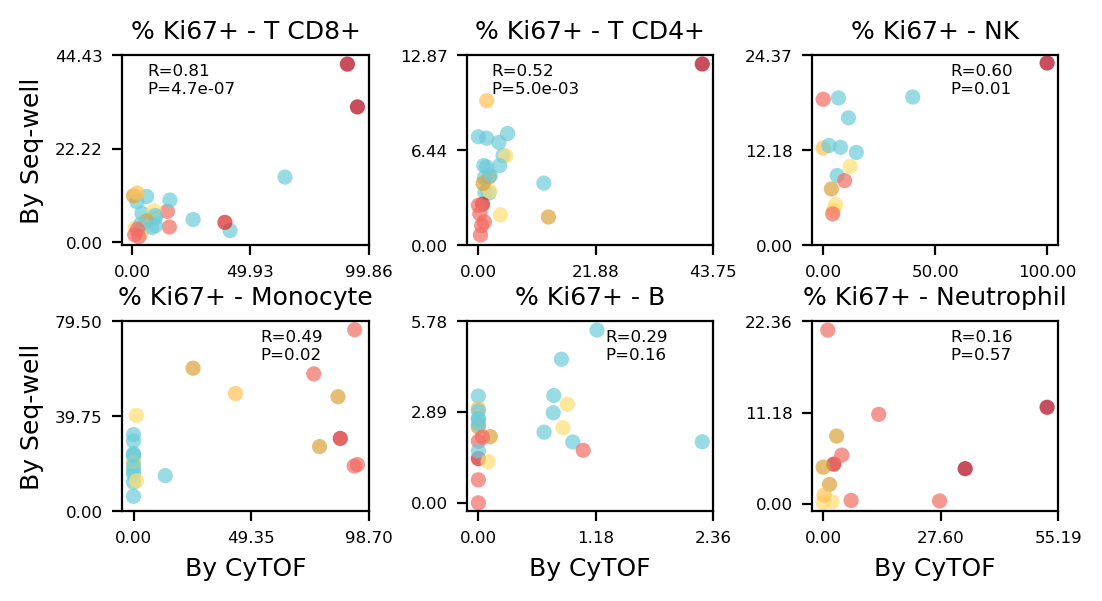

In [64]:
(fig,axes) = plt.subplots(2,3, figsize=(6,3), gridspec_kw={'wspace':.4, 'hspace':.4}, dpi=200)

renmap = {'Tc':'T CD8+', 'Th':'T CD4+', 'NK':'NK', 'Mono':'Monocyte', 'Neut':'Neutrophil', 'B':'B'}

axes = axes.ravel()

for (i,ct) in enumerate(['Tc', 'Th', 'NK', 'Mono', 'B', 'Neut']):
    ind = (cyt_seq_merge['Subclustering_reduced']==ct) & (cyt_seq_merge['count']>=10)
    cyt_seq_merge_ct = cyt_seq_merge.loc[ind,:]
    axes[i].scatter(cyt_seq_merge_ct['MAGIC_KI67'], cyt_seq_merge_ct['Ki67'], c=cyt_seq_merge_ct['color'],
                    s=30, edgecolor='None', alpha=.7)
    (R,P) = pearsonr(cyt_seq_merge_ct['MAGIC_KI67'], cyt_seq_merge_ct['Ki67'])
    print(ct, R, P)
    axes[i].set_title('% Ki67+ - ' + renmap[ct], fontsize=9)
    
    if i in [0, 1]:
        axes[i].text(0.1, 0.8, 'R=%.2f\nP=%.1e' % (R, P), fontsize=6, transform=axes[i].transAxes)
    elif i in [2,3,4,5]:
        axes[i].text(0.56, 0.8, 'R=%.2f\nP=%.2f' % (R, P), fontsize=6, transform=axes[i].transAxes)
    else:
        axes[i].text(0.12, 0.65, 'R=%.2f\nP=%.2f' % (R, P), fontsize=6, transform=axes[i].transAxes)
        
        
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    xticks = np.linspace(0, min(xlim[1], 100), 3)
    yticks = np.linspace(0, min(ylim[1], 100), 3)
    axes[i].set_xticks(xticks)
    axes[i].set_yticks(yticks)
    axes[i].set_xticklabels(['%.2f' % x for x in xticks], fontsize=6)
    axes[i].set_yticklabels(['%.2f' % x for x in yticks], fontsize=6)
    if i in [0,3]:
        axes[i].set_ylabel('By Seq-well', fontsize=9)
    else:
        axes[i].set_ylabel('')
        
    if i > 2:
        axes[i].set_xlabel('By CyTOF', fontsize=9)
    else:
        axes[i].set_xlabel('')
    axes[i].grid(False)
    
    
figure_file = os.path.join(results_dir, "Ki67Percentage.CyTOFvsSeqwell.Scatter.pdf")
fig.savefig(figure_file)
